In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [8]:
def load_mnist(num_training=55000, num_validation=5000, num_test=10000):

    # Load the raw mnist dataset and use appropriate data types and shapes
    mnist = tf.keras.datasets.mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Normalize the data: be in 0-1
    X_train = X_train / 255
    X_val = X_val / 255
    X_test = X_test / 255

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (55000, 28, 28)
Train labels shape:  (55000,) int32
Validation data shape:  (5000, 28, 28)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [9]:
def show_img(fig, images, kimgs, loc, xpo, ypo):
    plt.figure(fig)
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+4)
        plt.imshow(kimgs[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+7)
        xi = xpo[i,:]; yi = ypo[i,:]; t = len(xi)
        loci = loc[i,:,:]; n = loci.shape[0]
        s = np.linspace(25, 5, num=n)
        plt.plot(yi, -xi)
#         plt.plot(np.linspace(0,1,num=t), -xi)
#         plt.plot(yi, -np.linspace(0,1,num=t))
        plt.scatter(loci[:,1], -loci[:,0], s=s)
        plt.xlim(0,1); plt.ylim(-1,0)
    return

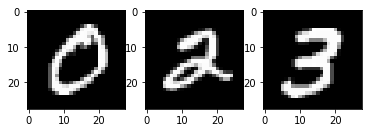

In [10]:
plt.figure(1)
plt.subplot(131)
plt.imshow(X_train[1,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(X_train[5,:,:], cmap='gray')
plt.subplot(133)
plt.imshow(X_train[7,:,:], cmap='gray')
plt.show()

In [11]:
def coding_net(inputs, num_filter=32, num_interior=3):
    """Coding Net for Image to get interior points and moments"""
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
    # Input Layer
    input_layer = tf.reshape(inputs, [-1,28,28,1])
    # First Convolution layer
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=num_filter,
        kernel_size=[5, 5],
        padding="same",
        kernel_regularizer=regularizer,
        activation=tf.nn.relu6)
    batch1 = tf.layers.batch_normalization(conv1,axis=1)
    pool1 = tf.layers.max_pooling2d(inputs=batch1, pool_size=[2, 2], strides=2)
    dropout1 = tf.layers.dropout(inputs=pool1, rate=0.5)
    
    # Second Convolution layer
    conv2 = tf.layers.conv2d(
        inputs=dropout1,
        filters=num_filter*2,
        kernel_size=[5, 5],
        padding="same",
        kernel_regularizer=regularizer,
        activation=tf.nn.relu6)
    batch2 = tf.layers.batch_normalization(conv2,axis=1)
    pool2 = tf.layers.max_pooling2d(inputs=batch2, pool_size=[2, 2], strides=2)
    dropout2 = tf.layers.dropout(inputs=pool2, rate=0.7)
    
    # Dense layer
    drop2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=drop2_flat, 
                            units=1024, 
                            kernel_regularizer=regularizer,
                            activation=tf.nn.relu6)
    dropout3 = tf.layers.dropout(inputs=dense, rate=0.5)
    
    # Output position and moments
    loc = tf.layers.dense(inputs=dropout3, 
                          units= (num_interior+2)*2, 
                          activation=tf.nn.sigmoid)
    moment = tf.layers.dense(inputs=dropout3, 
                             units= (num_interior+2)*2)
    loc = tf.reshape(loc, [-1, num_interior+2, 2])
    moment = tf.reshape(moment, [-1, num_interior+2, 2])
    return loc, moment

In [12]:
def reconstruction_xy(loc, moment, num_interior=3, num_points=30):
    """Using position and moments to reconstruct points on curve"""
    M = tf.constant([[1,0,0,0],[1,1,1,1],[0,1,0,0],[0,1,2,3]], 
                    dtype=tf.float64)
    M = tf.transpose(tf.linalg.inv(M))
    t_value = np.linspace(0,1, num = num_interior+2)
    
    tpoints = np.linspace(0, 1, num=num_points)
    basis = np.vstack([tpoints**0, tpoints**1, tpoints**2, tpoints**3])
    basis = tf.constant(basis, dtype=tf.float64)
    
    loc = tf.cast(loc, tf.float64); moment = tf.cast(moment, tf.float64)
    ### first interval
    i = 0
    
    x_i = tf.gather(loc, [i,i+1], axis=1)
    m_i = tf.gather(moment, [i,i+1], axis=1)
    xm_i = tf.concat([x_i, m_i], 1)
    
    coeff = tf.matmul(xm_i, M)
    curve = tf.matmul(coeff, basis)
    
    ### consequent intervals
    for i in range(1, num_interior+1):
        x_i = tf.gather(loc, [i,i+1], axis=1)
        m_i = tf.gather(moment, [i,i+1], axis=1)
        xm_i = tf.concat([x_i, m_i], 1)

        coeff_i = tf.matmul(xm_i, M)
        curve_i = tf.matmul(coeff_i, basis)
        
        coeff = tf.concat([coeff, coeff_i], 1)
        curve = tf.concat([curve, curve_i], 1)
    return curve, coeff

def reconstruction(loc, moment, num_interior=3, num_points=30):
    x_points, x_coeff = reconstruction_xy(loc[:,:,0], moment[:,:,0], num_interior, num_points)
    y_points, y_coeff = reconstruction_xy(loc[:,:,1], moment[:,:,1], num_interior, num_points)
    
    return x_points, y_points, x_coeff, y_coeff

In [13]:
index_tensor = np.zeros([28,28,2])
for i in range(28):
    for j in range(28):
        index_tensor[i,j,:] = [i/27.0, j/27.0]
        
def kernel_image(x_points, y_points, sigma=0.02, scale=1):
    locations = tf.constant(index_tensor, dtype=tf.float64)
    points = tf.stack([x_points, y_points], axis=2)
    dist = tf.einsum("iju,ntu->nijt", locations**2, tf.ones_like(points)) -\
           2 * tf.einsum("iju,ntu->nijt", locations, points) +\
           tf.einsum("iju,ntu->nijt", tf.ones_like(locations), points**2)
    kernel = tf.exp(-(0.5 * sigma**(-2)) * dist)
    images = tf.reduce_sum(kernel, axis=3)
    images = tf.tanh(images)**2 
    images = tf.cast(images, tf.float64)
    
    return images

def loss(kernel_img, images):
    images = tf.cast(images, tf.float64)
    return tf.reduce_mean( (kernel_img - images)**2 )

In [14]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 28, 28])
Images = tf.placeholder(tf.float32, [None, 28, 28])
learning_rate = tf.placeholder(tf.float32, shape=[])

num_interior = 3; num_points = 20

loc, moment = coding_net(X, num_interior = num_interior)
x_points, y_points, _, _ = reconstruction(loc, moment, num_interior, num_points)

reg = 1; sigma=0.025; lam_sep = 1e-3; lam_len = 5e-3; lam_smooth = 1e-2
 
kernel_imgs = kernel_image(x_points,y_points, sigma=sigma)
total_loss = loss(kernel_imgs,Images)

totalp = (num_interior+1)*num_points
xdiff = x_points[:,1:totalp] - x_points[:,:(totalp-1)]
ydiff = y_points[:,1:totalp] - y_points[:,:(totalp-1)]
loc_xdiff = loc[:,1:(num_interior+2),0] - loc[:,:(num_interior+1),0]
loc_ydiff = loc[:,1:(num_interior+2),1] - loc[:,:(num_interior+1),1]

eps = 1e-8
length_penalty = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.sqrt(
                            tf.clip_by_value(xdiff**2 + ydiff**2, eps, 1)
                        ),
                        axis = 1
                    )
                 )

sep_penalty = -tf.reduce_mean(
                    tf.reduce_sum(
                        tf.sqrt(loc_xdiff**2 + loc_ydiff**2),
                        axis = 1
                    )
                 )

smooth_penalty = tf.reduce_mean((
                    moment[:,1:(num_interior+2),:] - moment[:,:(num_interior+1),:]
                 )**2)

total_loss = tf.cast(total_loss, tf.float64) + \
             reg * tf.cast(tf.losses.get_regularization_loss(), tf.float64) +\
             lam_sep * tf.cast(sep_penalty, tf.float64) +\
             lam_len * tf.cast(length_penalty, tf.float64) +\
             lam_smooth * tf.cast(smooth_penalty, tf.float64) 
            
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(total_loss)

Training
Iteration 0: with minibatch training loss = 0.906 val loss = 0.732


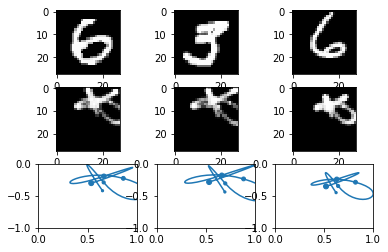

Iteration 200: with minibatch training loss = 0.0711 val loss = 0.0781


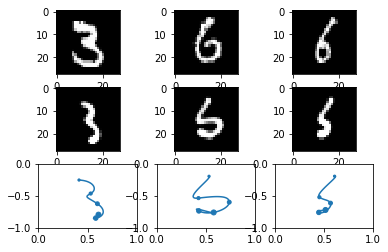

Iteration 400: with minibatch training loss = 0.0628 val loss = 0.0645


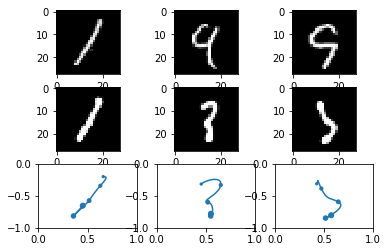

Iteration 600: with minibatch training loss = 0.0594 val loss = 0.055


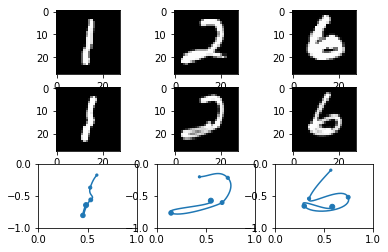

Iteration 800: with minibatch training loss = 0.0543 val loss = 0.0552


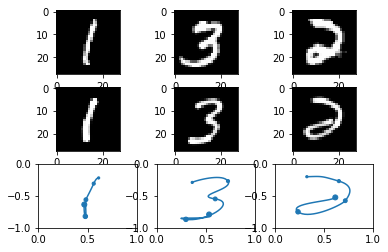

Epoch 1, Overall loss = 0.0727
Learning Rate: 0.0005


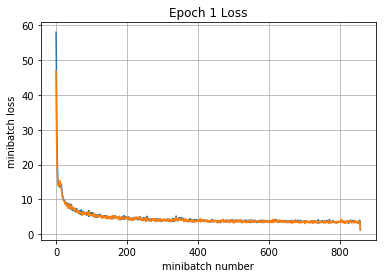

Iteration 1000: with minibatch training loss = 0.0539 val loss = 0.0481


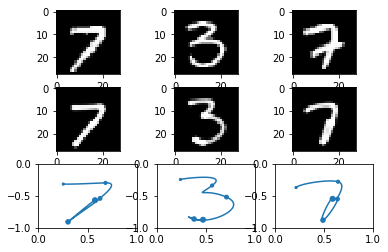

Iteration 1200: with minibatch training loss = 0.0496 val loss = 0.0466


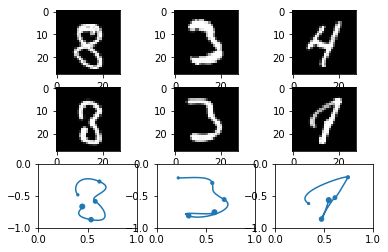

Iteration 1400: with minibatch training loss = 0.0432 val loss = 0.0465


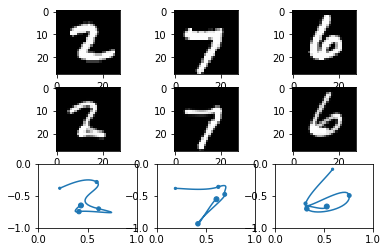

Iteration 1600: with minibatch training loss = 0.0525 val loss = 0.0437


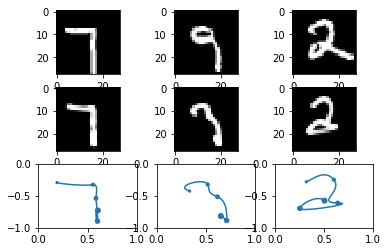

Epoch 2, Overall loss = 0.0471


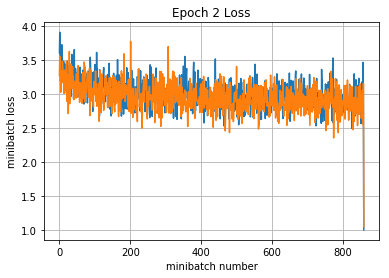

Iteration 1800: with minibatch training loss = 0.0458 val loss = 0.0494


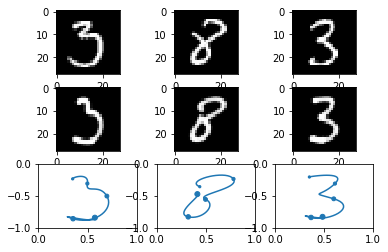

Iteration 2000: with minibatch training loss = 0.0471 val loss = 0.0435


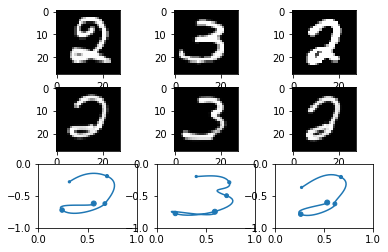

Iteration 2200: with minibatch training loss = 0.0479 val loss = 0.0465


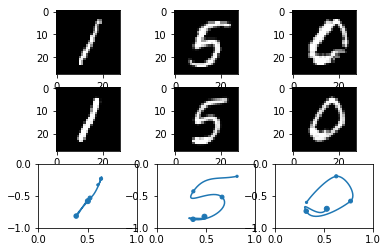

Iteration 2400: with minibatch training loss = 0.0434 val loss = 0.0419


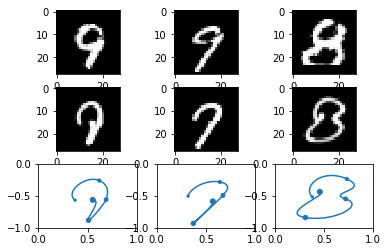

Epoch 3, Overall loss = 0.0446


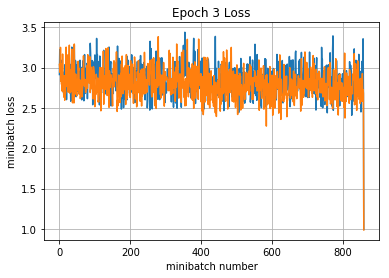

Iteration 2600: with minibatch training loss = 0.0389 val loss = 0.0424


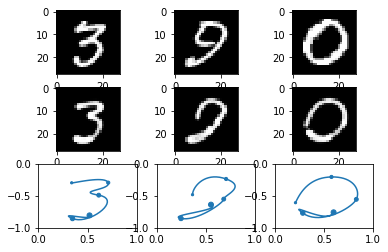

Iteration 2800: with minibatch training loss = 0.0464 val loss = 0.0429


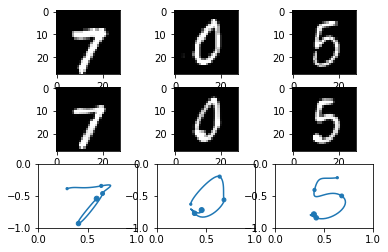

Iteration 3000: with minibatch training loss = 0.0471 val loss = 0.045


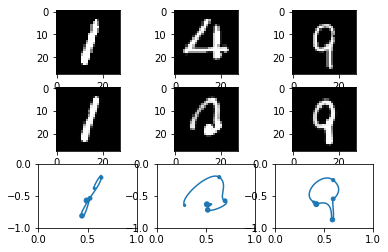

Iteration 3200: with minibatch training loss = 0.0472 val loss = 0.0454


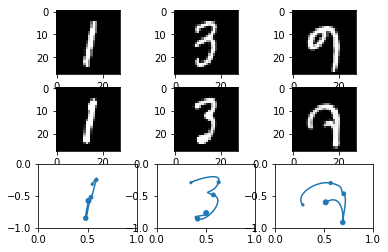

Iteration 3400: with minibatch training loss = 0.0439 val loss = 0.043


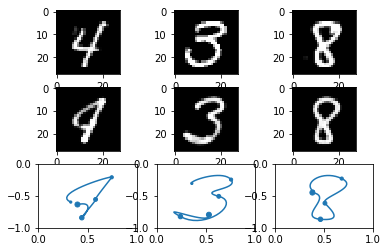

Epoch 4, Overall loss = 0.0432


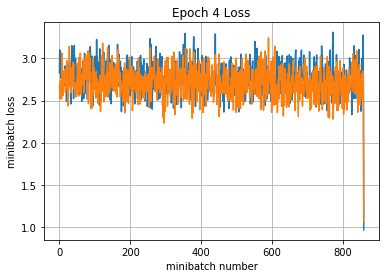

Iteration 3600: with minibatch training loss = 0.0399 val loss = 0.0418


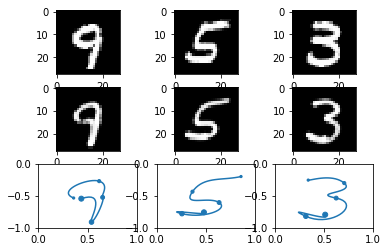

Iteration 3800: with minibatch training loss = 0.0434 val loss = 0.041


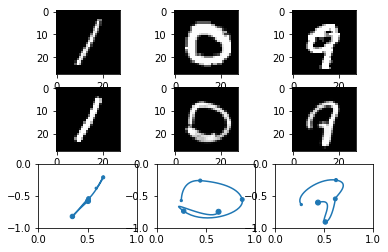

Iteration 4000: with minibatch training loss = 0.0422 val loss = 0.0435


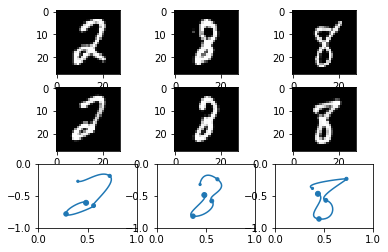

Iteration 4200: with minibatch training loss = 0.0422 val loss = 0.0467


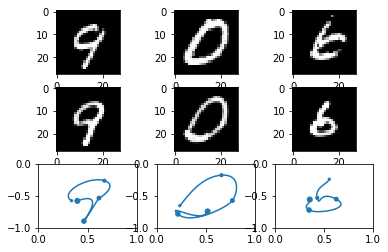

Epoch 5, Overall loss = 0.0423


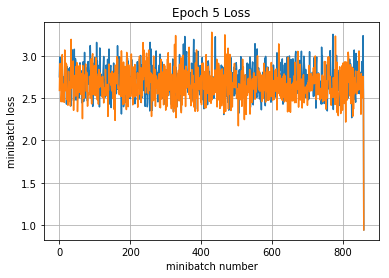

In [15]:
def run_model(session, total_loss, train_step, Xd, Xval, lr, 
              epochs=5, batch_size=64, print_every=100,
              plot_losses=True):

    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)    
    
    iter_cnt = 0
    fig = 1
    for e in range(epochs):
        losses = []
        val_losses = []
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            feed_dict = {X: Xd[idx,:,:],
                         Images: Xd[idx,:,:]}

            actual_batch_size = Xd[idx,:,:].shape[0]
            
            loss = session.run(total_loss, feed_dict=feed_dict)
            session.run(train_step, {X: Xd[idx,:,:],
                                     Images: Xd[idx,:,:],
                                     learning_rate: lr})
            
            ri = np.random.randint(0,5000,size=batch_size)
            val_dict = {X: Xval[ri,:,:],
                        Images: Xval[ri,:,:]}
            val_loss = session.run(total_loss, val_dict)
            
            losses.append(loss*actual_batch_size)
            val_losses.append(val_loss*actual_batch_size)
            
            # print every now and then
            if (iter_cnt % print_every) == 0:
                
                print("Iteration {0}: with minibatch training loss = {1:.3g} val loss = {2:.3g}"\
                      .format(iter_cnt,loss, val_loss))
                
                ### show img
                val_ind = np.random.randint(0,5000,size=3)
                
                feed_dict_val = {X: Xval[val_ind,:,:],
                                 Images: Xval[val_ind,:,:]}
                
                locations = session.run(loc, feed_dict_val)
                xpo, ypo = session.run([x_points, y_points], feed_dict_val)
                kimgs_val = session.run(kernel_imgs, feed_dict_val) 
                
                show_img(fig, Xval[val_ind,:,:], kimgs_val, locations, xpo,ypo)
                fig += 1
                plt.show()
                
            iter_cnt += 1
        mean_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(mean_loss,e+1))
        if e % 10 == 0:
            lr /= 10
            print("Learning Rate: {0:.3g}".format(lr))
        if plot_losses:
            plt.plot(losses,label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return mean_loss

sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess, total_loss, train_step, X_train,X_val, 5e-3, 5,64,200, True)
    
    
###########################################################################
##
##  See the training result below
##  First line is true digit picture from validation set
##  Second line is reconstruction map from curve fitting
##  Third line is curve plot
##
##  After 1000 iteration the result should be fine
##  But it will struggle with some digits, say 4 or 5
##  
############################################################################

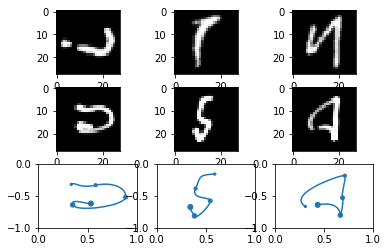

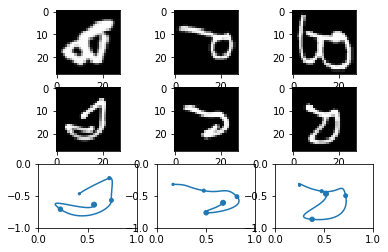

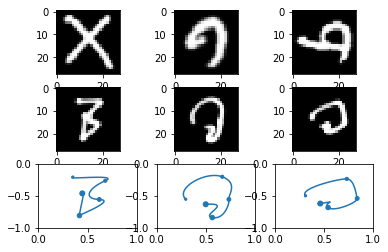

In [23]:
###################################################
##
##  Now let's see can it generalize well to 
##  Handwritten Letters, which should be  
##  totally different from digit
##  You should see it's struggling and behave
##  like using a digit to approximate the letter
##  But for those simple letter results looks good
##
###################################################


letter = np.load("letter_data.npy")

test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()

test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()

test_ind = np.random.randint(0,10000,size=3)
                
feed_dict_test = {X: letter[test_ind,:,:],
                 Images: letter[test_ind,:,:]}

locations = sess.run(loc, feed_dict_test)
xpo, ypo = sess.run([x_points, y_points], feed_dict_test)
kimgs_test = sess.run(kernel_imgs, feed_dict_test) 

show_img(1, letter[test_ind,:,:],kimgs_test,locations,xpo,ypo)
plt.show()